In [152]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [154]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [155]:
df = pd.read_csv('results/master_file.csv', sep=';')

In [156]:
df.shape

(231082, 12)

In [157]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [158]:
df = df[df['Test Result'] != 'FAIL'].copy()

In [159]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,227147,227147,227147.000000,227147,227147.000000,227147.000000,227147.000000,227147.000000,227147
unique,41,4,NaN,227147,NaN,NaN,NaN,NaN,1
top,/g/user,POST,NaN,2023-04-17 22:46:11.990,NaN,NaN,NaN,NaN,PASS
freq,72398,108900,NaN,1,NaN,NaN,NaN,NaN,227147
mean,NaN,NaN,229.855235,NaN,652.630983,726.718253,112.204220,606.360388,NaN
std,NaN,NaN,71.940591,NaN,1864.796288,3000.289744,215.787415,1058.297251,NaN
min,NaN,NaN,200.000000,NaN,0.000000,2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,68.000000,72.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,121.000000,126.000000,36.000000,177.000000,NaN
75%,NaN,NaN,200.000000,NaN,529.000000,543.000000,83.000000,959.000000,NaN


In [160]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

# The average response time by endpoint

In [161]:
grouped = df.groupby('Endpoint')['Duration till body received[ms]'].mean()

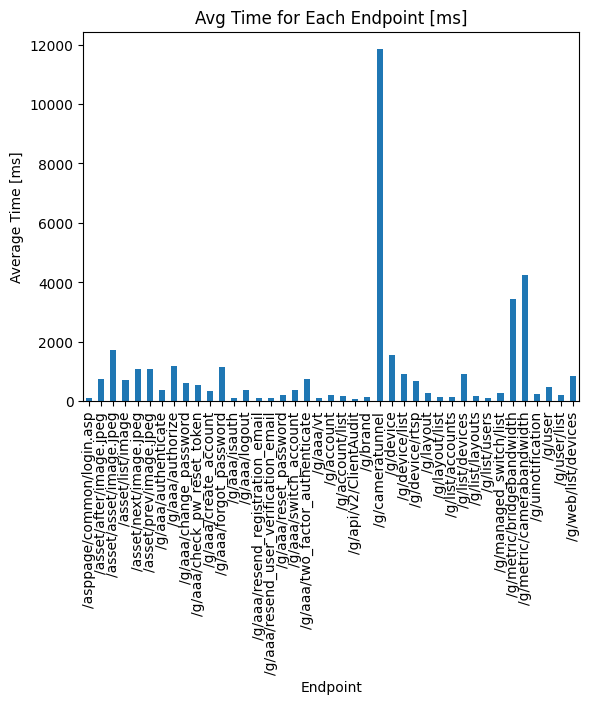

In [162]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Breakdown: average response time by endpoint compared to avg time today

In [163]:
import pandas as pd
from datetime import datetime, timedelta
import pytz


avg_duration = df.groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration = avg_duration.rename(columns={'Duration till body received[ms]': 'avg_duration'})

# get the average duration for the last 24 hours
#last_24_hours = datetime.now() - timedelta(hours=24)
last_24_hours = datetime.now(tz=pytz.timezone('US/Central')) - timedelta(hours=24)
avg_duration_last_24_hours = df[df['Start Time CST'] >= last_24_hours].groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration_last_24_hours = avg_duration_last_24_hours.rename(columns={'Duration till body received[ms]': 'avg_duration 24_hrs'})

# merge the two dataframes on the 'endpoints' column
result = pd.merge(avg_duration, avg_duration_last_24_hours, on='Endpoint', how='left')

# print the result
print(result)

                                 Endpoint  avg_duration  avg_duration 24_hrs
0               /asppage/common/login.asp    119.510436           116.000000
1                 /asset/after/image.jpeg    744.853282           239.181818
2                 /asset/asset/image.jpeg   1716.293173          2151.800000
3                       /asset/list/image    715.104418           156.000000
4                  /asset/next/image.jpeg   1081.296443           225.100000
5                  /asset/prev/image.jpeg   1081.384030           471.200000
6                     /g/aaa/authenticate    370.703023           240.518455
7                        /g/aaa/authorize   1178.552859           873.984503
8                  /g/aaa/change_password    598.191369           708.531323
9             /g/aaa/check_pw_reset_token    545.932856           489.651163
10                  /g/aaa/create_account    341.015421           199.757576
11                 /g/aaa/forgot_password   1136.308256           973.142077

### Worst performaning endpoint all time

In [164]:
df_sorted = df.sort_values(by='Duration till body received[ms]', ascending=False)
df_sorted.iloc[0]

Endpoint                                     /g/metric/camerabandwidth
Method                                                             GET
Status Code                                                        200
Start time                                  2023-04-11 22:05:12.339000
Duration till headers received[ms]                              167193
Duration till body received[ms]                                 167197
Request Body Length                                                  0
Response Body Length                                              8899
Test Result                                                       PASS
Start Time CST                        2023-04-11 17:05:12.339000-05:00
Name: 24656, dtype: object

### Worst performaning endpoint last 24 hours

In [165]:
df_last_24_hrs = df[df['Start Time CST'] >= last_24_hours]
#print (df[df_huh['Duration till body received[ms]'].idxmax()])
df_last_24_hrs = df_last_24_hrs.sort_values(by='Duration till body received[ms]', ascending=False)
max_duration_row = df_last_24_hrs.iloc[0]
print (max_duration_row)

Endpoint                                               /g/cameratunnel
Method                                                             GET
Status Code                                                        200
Start time                                  2023-04-17 21:48:43.108000
Duration till headers received[ms]                                 330
Duration till body received[ms]                                 118744
Request Body Length                                                  0
Response Body Length                                                52
Test Result                                                       PASS
Start Time CST                        2023-04-17 16:48:43.108000-05:00
Name: 211823, dtype: object


## Median response time at each hour - all endpoints

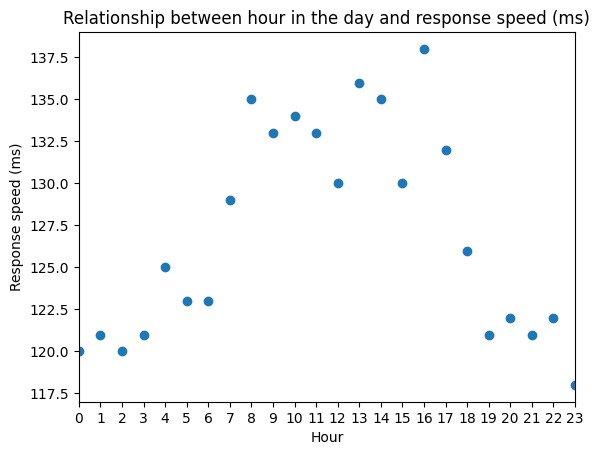

In [166]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Median response time at each day - all endpoints

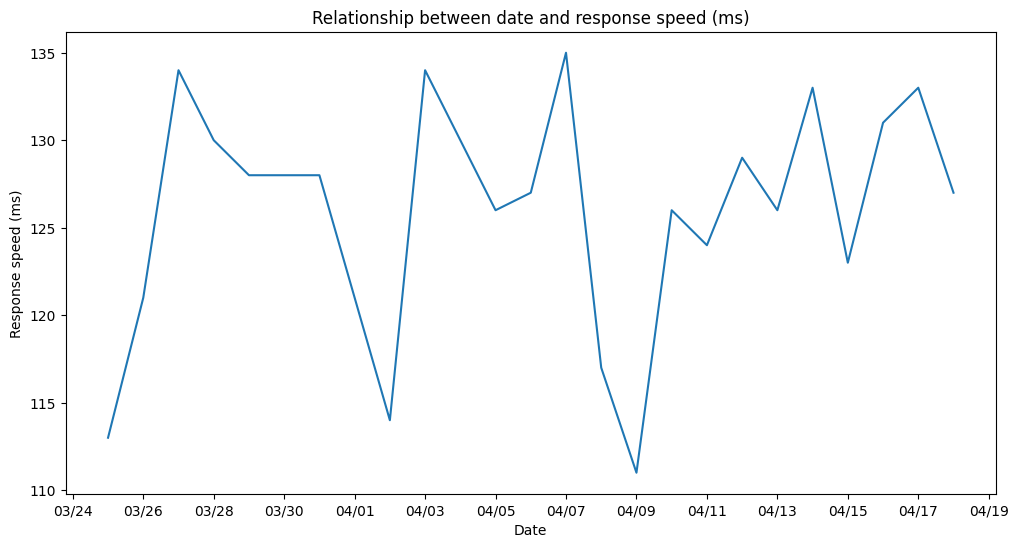

In [167]:
from matplotlib import dates as mpl_dates
import matplotlib.ticker as ticker


# Create a new column with the date value
df['Date'] = df['Start Time CST'].dt.date

# Calculate the mean duration for each day
daily_mean_duration = df.groupby('Date')['Duration till body received[ms]'].median()

# Create a new dataframe with all dates included
all_dates = pd.DataFrame({'Date': pd.date_range(start=df['Start Time CST'].min().date(), end=df['Start Time CST'].max().date())})

# Concatenate the daily mean duration data with the all-dates dataframe
result = pd.concat([all_dates.set_index('Date'), daily_mean_duration], axis=1, join='outer')

# Forward fill the missing values
result['Duration till body received[ms]'] = result['Duration till body received[ms]'].fillna(method='ffill')

# Build line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result.index, result['Duration till body received[ms]'])
ax.set_xlabel('Date')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between date and response speed (ms)')

# Format the x-axis tick labels to display only the month and day
date_format = mpl_dates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))


plt.show()

## Speed throughout the day for endpoint - g/aaa/authenticate

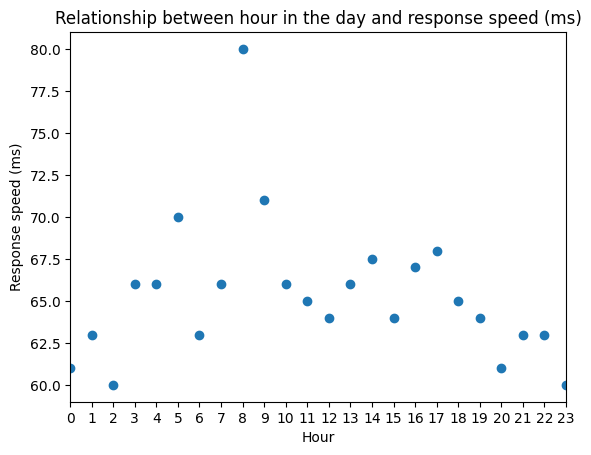

In [168]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

# The response length by endpoint

In [169]:
grouped = df.groupby('Endpoint')['Response Body Length'].mean()

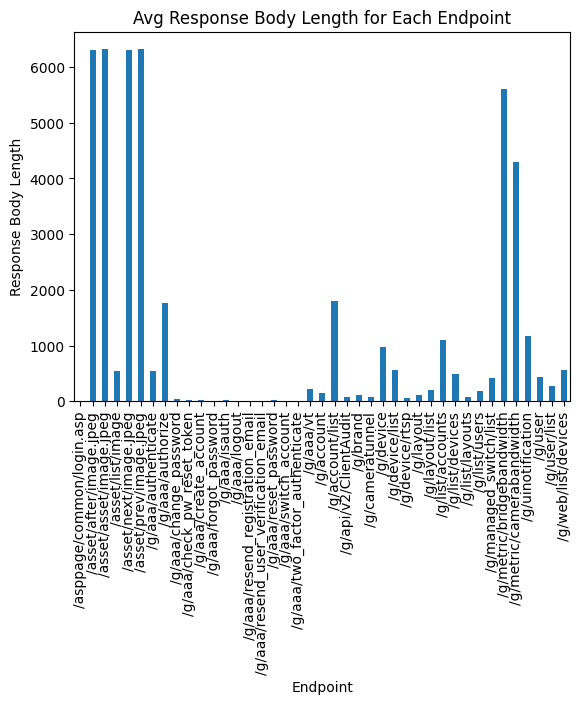

In [170]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()